In [3]:
pip install --upgrade category_encoders

     |████████████████████████████████| 81kB 8.6MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import xgboost
import lightgbm
import category_encoders as ce

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df = pd.read_csv('/content/Train.csv', nrows=1000)
df.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,B,Urban,7500,1


In [6]:
X = df.drop('renewal', axis=1)
y = df['renewal']
y.value_counts()

1    930
0     70
Name: renewal, dtype: int64

In [7]:
# X = X.fillna(-1)
X.isnull().sum()

perc_premium_paid_by_cash_credit     0
age_in_days                          0
Income                               0
Count_3.6_months_late                1
Count_6.12_months_late               1
Count_more_than_12_months_late       1
application_underwriting_score      36
no_of_premiums_paid                  0
sourcing_channel                     0
residence_area_type                  0
premium                              0
dtype: int64

In [8]:
cat_features = ['sourcing_channel',	'residence_area_type']
encoder = ce.CatBoostEncoder(cols=cat_features)
encoder.fit(X[cat_features], y)
X = X.join(encoder.transform(X[cat_features]).add_suffix('_cb'))
X.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,sourcing_channel_cb,residence_area_type_cb
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,0.918446,0.929624
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0.918446,0.930590
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,0.942034,0.929624
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,0.936045,0.929624
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,B,Urban,7500,0.936045,0.929624


In [9]:
X = X.drop(cat_features, axis=1)

In [10]:
Xnew = X.copy()
cols = X.columns
i = 0
for c1 in cols:
  j = 0
  for c2 in cols:
    if i<j:
      Xnew[c1+'/'+c2] = (Xnew[c1]+0.0001) / (Xnew[c2]+0.0001)
    j += 1
  i+= 1
Xnew.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,sourcing_channel_cb,residence_area_type_cb,perc_premium_paid_by_cash_credit/age_in_days,perc_premium_paid_by_cash_credit/Income,perc_premium_paid_by_cash_credit/Count_3.6_months_late,perc_premium_paid_by_cash_credit/Count_6.12_months_late,perc_premium_paid_by_cash_credit/Count_more_than_12_months_late,perc_premium_paid_by_cash_credit/application_underwriting_score,perc_premium_paid_by_cash_credit/no_of_premiums_paid,perc_premium_paid_by_cash_credit/premium,perc_premium_paid_by_cash_credit/sourcing_channel_cb,perc_premium_paid_by_cash_credit/residence_area_type_cb,age_in_days/Income,age_in_days/Count_3.6_months_late,age_in_days/Count_6.12_months_late,age_in_days/Count_more_than_12_months_late,age_in_days/application_underwriting_score,age_in_days/no_of_premiums_paid,age_in_days/premium,age_in_days/sourcing_channel_cb,age_in_days/residence_area_type_cb,Income/Count_3.6_months_late,Income/Count_6.12_months_late,Income/Count_more_than_12_months_late,Income/application_underwriting_score,Income/no_of_premiums_paid,Income/premium,Income/sourcing_channel_cb,Income/residence_area_type_cb,Count_3.6_months_late/Count_6.12_months_late,Count_3.6_months_late/Count_more_than_12_months_late,Count_3.6_months_late/application_underwriting_score,Count_3.6_months_late/no_of_premiums_paid,Count_3.6_months_late/premium,Count_3.6_months_late/sourcing_channel_cb,Count_3.6_months_late/residence_area_type_cb,Count_6.12_months_late/Count_more_than_12_months_late,Count_6.12_months_late/application_underwriting_score,Count_6.12_months_late/no_of_premiums_paid,Count_6.12_months_late/premium,Count_6.12_months_late/sourcing_channel_cb,Count_6.12_months_late/residence_area_type_cb,Count_more_than_12_months_late/application_underwriting_score,Count_more_than_12_months_late/no_of_premiums_paid,Count_more_than_12_months_late/premium,Count_more_than_12_months_late/sourcing_channel_cb,Count_more_than_12_months_late/residence_area_type_cb,application_underwriting_score/no_of_premiums_paid,application_underwriting_score/premium,application_underwriting_score/sourcing_channel_cb,application_underwriting_score/residence_area_type_cb,no_of_premiums_paid/premium,no_of_premiums_paid/sourcing_channel_cb,no_of_premiums_paid/residence_area_type_cb,premium/sourcing_channel_cb,premium/residence_area_type_cb,sourcing_channel_cb/residence_area_type_cb
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,3300,0.918446,0.929624,0.000036,1.208528e-06,4291.000000,4291.00000,4291.000000,0.004333,0.033007,0.000130,0.467151,0.461535,0.033960,1.205800e+08,1.205800e+08,1.205800e+08,121.773257,927.531334,3.653939,13127.269412,12969.437948,3.550600e+09,3.550600e+09,3.550600e+09,3585.736634,27312.097607,107.593936,386545.715723,381898.208727,1.000000,1.0000,0.000001,0.000008,3.030303e-08,0.000109,0.000108,1.0000,0.000001,0.000008,3.030303e-08,0.000109,0.000108,0.000001,0.000008,3.030303e-08,0.000109,0.000108,7.616872,0.030006,107.800922,106.504813,0.003939,14.152912,13.982749,3592.634766,3549.439888,0.987977
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,3300,0.918446,0.930590,0.000052,1.089969e-05,0.458527,0.30569,0.917008,0.009293,0.131012,0.000278,0.998426,0.985398,0.208355,8.765062e+03,5.843472e+03,1.752925e+04,177.636866,2504.392809,5.312424,19085.599558,18836.567418,4.206790e+04,2.804573e+04,8.413159e+04,852.567786,12019.828302,25.496969,91601.297106,90406.067843,0.666678,1.9999,0.020266,0.285724,6.060909e-04,2.177463,2.149051,2.9998,0.030399,0.428580,9.091212e-04,3.266140,3.223523,0.010134,0.142869,3.030606e-04,1.088786,1.074579,14.098384,0.029906,107.441659,106.039742,0.002121,7.620849,7.521411,3592.634766,3545.757459,0.986952
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,9600,0.942034,0.929624,0.000003,1.960002e-07,491.000000,491.00000,491.000000,0.000493,0.005455,0.000005,0.052116,0.052811,0.061239,1.534100e+08,1.534

In [15]:
X = X.fillna(0)

In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xnew, y, test_size=0.2)

In [17]:
Xnew.shape

(1000, 66)

In [19]:
# Feature ranking with recursive feature elimination.
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=10, step=5)
selector = selector.fit(Xnew, y)
selector.support_
# selector.ranking_

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
# The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature.
# Selected features are assigned rank 1.

In [ ]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=15, learning_rate=0.011, colsample_bytree=0.85,
                              verbose=1, class_weight='balanced')
lgb.fit(Xtrain, Ytrain, eval_set=(Xtest, Ytest), verbose=100, early_stopping_rounds=50)
pred = lgb.predict(Xtest, num_iteration=lgb.best_iteration_)
print(f1_score(Ytest, pred, pos_label=0))

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's binary_logloss: 0.350997
[200]	valid_0's binary_logloss: 0.266294
[300]	valid_0's binary_logloss: 0.251271
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.249699
0.5294117647058824


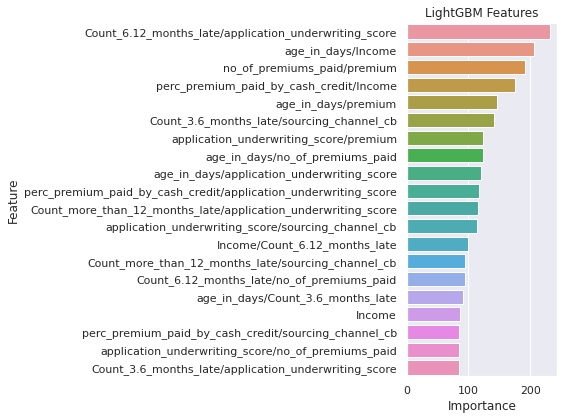

,Importance,Feature
46,232,Count_6.12_months_late/application_underwritin...
21,206,age_in_days/Income
60,192,no_of_premiums_paid/premium
12,175,perc_premium_paid_by_cash_credit/Income
27,146,age_in_days/premium
...,...,...
45,0,Count_6.12_months_late/Count_more_than_12_mont...
5,0,Count_more_than_12_months_late
4,0,Count_6.12_months_late
37,0,Income/residence_area_type_cb


In [ ]:
imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':Xnew.columns})
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="Importance", y="Feature", data=imp.sort_values(by="Importance", ascending=False)[:20])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
imp.sort_values(by="Importance", ascending=False)

In [ ]:
imp = imp.sort_values(by="Importance", ascending=False)
best_feats = list(imp['Feature'].values[:7])
best_feats

['Count_6.12_months_late/application_underwriting_score',
 'age_in_days/Income',
 'no_of_premiums_paid/premium',
 'perc_premium_paid_by_cash_credit/Income',
 'age_in_days/premium',
 'Count_3.6_months_late/sourcing_channel_cb',
 'application_underwriting_score/premium']

In [ ]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=200000, num_leaves=15, learning_rate=0.011, colsample_bytree=0.9,
                              verbose=1, class_weight='balanced')
lgb.fit(Xtrain[best_feats], Ytrain, eval_set=(Xtest[best_feats], Ytest), verbose=500, early_stopping_rounds=50)
pred = lgb.predict(Xtest[best_feats], num_iteration=lgb.best_iteration_)
print(f1_score(Ytest, pred, pos_label=0))

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[255]	valid_0's binary_logloss: 0.29172
0.5555555555555556


In [ ]:
# Permutation Importance
def premutation_importance(Xtrain, Xtest, Ytrain, Ytest):
  lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=500, num_leaves=15, learning_rate=0.011, colsample_bytree=0.85,
                              verbose=0, class_weight='balanced')
  lgb.fit(Xtrain, Ytrain, eval_set=(Xtest, Ytest), verbose=0, early_stopping_rounds=20)
  pred = lgb.predict(Xtest, num_iteration=lgb.best_iteration_)
  baseline = f1_score(Ytest, pred, pos_label=0)

  perm = {}
  features = Xtrain.columns
  for f in features:
      value = Xtrain[f].copy()

      Xtrain[f] = np.random.permutation(Xtrain[f].values)
      lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=500, num_leaves=15, learning_rate=0.011, colsample_bytree=0.85,
                              verbose=0, class_weight='balanced')
      lgb.fit(Xtrain, Ytrain, eval_set=(Xtest, Ytest), verbose=0, early_stopping_rounds=20)
      pred = lgb.predict(Xtest, num_iteration=lgb.best_iteration_)
      f1 = f1_score(Ytest, pred, pos_label=0)

      Xtrain[f] = np.random.permutation(Xtrain[f].values)
      lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=500, num_leaves=15, learning_rate=0.011, colsample_bytree=0.85,
                              verbose=0, class_weight='balanced')
      lgb.fit(Xtrain, Ytrain, eval_set=(Xtest, Ytest), verbose=0, early_stopping_rounds=20)
      pred = lgb.predict(Xtest, num_iteration=lgb.best_iteration_)
      f2 = f1_score(Ytest, pred, pos_label=0)

      perm[f] = baseline - (f1+f2)/2
      print(f, perm[f])

      Xtrain[f] = value.copy()

  perm_df = pd.DataFrame({'feature':list(perm.keys()), 'weight':list(perm.values())})
  perm_df = perm_df.sort_values('weight', ascending=False)[:20]
  perm_df = perm_df[perm_df.weight>=0]
  best_features = list(perm_df['feature'].values)

  return best_features

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xnew, y, test_size=0.2)
best_features = premutation_importance(Xtrain, Xtest, Ytrain, Ytest)

perc_premium_paid_by_cash_credit 0.058064516129032295
age_in_days 0.14050179211469543
Income 0.09032258064516135
Count_3.6_months_late 0.07919911012235825
Count_6.12_months_late 0.0
Count_more_than_12_months_late 0.0
application_underwriting_score 0.03225806451612906
no_of_premiums_paid 0.13634196726521536
premium 0.11368186874304786
sourcing_channel_cb 0.10678531701890992
residence_area_type_cb 0.05339265850945496
perc_premium_paid_by_cash_credit/age_in_days 0.189247311827957
perc_premium_paid_by_cash_credit/Income 0.08494623655913985
perc_premium_paid_by_cash_credit/Count_3.6_months_late 0.1458657767890249
perc_premium_paid_by_cash_credit/Count_6.12_months_late 0.12572004608294934
perc_premium_paid_by_cash_credit/Count_more_than_12_months_late 0.09139784946236562
perc_premium_paid_by_cash_credit/application_underwriting_score 0.18875576036866365
perc_premium_paid_by_cash_credit/no_of_premiums_paid 0.06979472140762466
perc_premium_paid_by_cash_credit/premium 0.14208909370199696
perc_p

In [ ]:
best_features

['Income/sourcing_channel_cb',
 'perc_premium_paid_by_cash_credit/age_in_days',
 'perc_premium_paid_by_cash_credit/application_underwriting_score',
 'age_in_days/Count_more_than_12_months_late',
 'age_in_days/application_underwriting_score',
 'perc_premium_paid_by_cash_credit/Count_3.6_months_late',
 'perc_premium_paid_by_cash_credit/premium',
 'Income/Count_more_than_12_months_late',
 'age_in_days/sourcing_channel_cb',
 'age_in_days',
 'no_of_premiums_paid',
 'Count_3.6_months_late/premium',
 'Count_6.12_months_late/sourcing_channel_cb',
 'age_in_days/Income',
 'age_in_days/Count_6.12_months_late',
 'perc_premium_paid_by_cash_credit/Count_6.12_months_late',
 'Count_3.6_months_late/Count_more_than_12_months_late',
 'Count_6.12_months_late/no_of_premiums_paid',
 'application_underwriting_score/premium',
 'age_in_days/no_of_premiums_paid']

In [ ]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=20000, num_leaves=15, learning_rate=0.011, colsample_bytree=0.9,
                              verbose=1, class_weight='balanced')
lgb.fit(Xtrain[best_feats], Ytrain, eval_set=(Xtest[best_feats], Ytest), verbose=500, early_stopping_rounds=50)
pred = lgb.predict(Xtest[best_feats], num_iteration=lgb.best_iteration_)
print(f1_score(Ytest, pred, pos_label=0))

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.334003
0.3243243243243243


In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 4.5MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=20000, num_leaves=15, learning_rate=0.011, colsample_bytree=0.9,
                              verbose=1, class_weight='balanced')
lgb.fit(Xtrain, Ytrain, eval_set=(Xtest, Ytest), verbose=500, early_stopping_rounds=50)
pred = lgb.predict(Xtest, num_iteration=lgb.best_iteration_)
print(f1_score(Ytest, pred, pos_label=0))

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[317]	valid_0's binary_logloss: 0.254023
0.39999999999999997


In [ ]:
Xnew = Xnew.fillna(0)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xnew, y, test_size=0.2)
perm = PermutationImportance(lgb, random_state=2020).fit(Xtest, Ytest)

In [ ]:
eli5.show_weights(perm, feature_names = Xtest.columns.tolist(), top=66)

Weight,Feature
0.0190 ± 0.0117,age_in_days/application_underwriting_score
0.0090 ± 0.0040,Count_more_than_12_months_late/application_underwriting_score
0.0090 ± 0.0133,Count_6.12_months_late/sourcing_channel_cb
0.0080 ± 0.0102,Income/premium
0.0070 ± 0.0080,Count_6.12_months_late/application_underwriting_score
0.0050 ± 0.0089,application_underwriting_score
0.0050 ± 0.0000,Income/Count_3.6_months_late
0.0050 ± 0.0063,Count_6.12_months_late/no_of_premiums_paid
0.0050 ± 0.0063,perc_premium_paid_by_cash_credit/sourcing_channel_cb
0.0050 ± 0.0000,Count_more_than_12_months_late/residence_area_type_cb
